# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1K-FbQcggVDqvEAK6U44FLsF7Ho1kTaQj#scrollTo=zbnrp2ig1pps

Share Link: https://drive.google.com/file/d/1K-FbQcggVDqvEAK6U44FLsF7Ho1kTaQj/view?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-529-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
# there are 32561 rows (records) in the data frame, and 14 columns (features)
df.shape

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify

*   List item
*   List item


entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
#Calculate min, mean and max for feature "age"
agemean=df["age"].mean()
agemax=df["age"].max()
agemin=df["age"].min()
print(f"AGE: mean {agemean}, max {agemax}, min {agemin}")

#Calculate min, mean and max for feature "yredu"
yredumean=df["yredu"].mean()
yredumax=df["yredu"].max()
yredumin=df["yredu"].min()
print(f"YREDU: mean {yredumean}, max {yredumax}, min {yredumin}")

#Calculate min, mean and max for feature "capgain"
capgainmean=df["capgain"].mean()
capgainmax=df["capgain"].max()
capgainmin=df["capgain"].min()
print(f"CAPGAIN: mean {capgainmean}, max {capgainmax}, min {capgainmin}")

#Calculate min, mean and max for feature "caploss"
caplossmean=df["caploss"].mean()
caplossmax=df["caploss"].max()
caplossmin=df["caploss"].min()
print(f"CAPLOSS: mean {caplossmean}, max {caplossmax}, min {caplossmin}")

#Calculate min, mean and max for feature "workhr"
workhrmean=df["workhr"].mean()
workhrmax=df["workhr"].max()
workhrmin=df["workhr"].min()
print(f"WORKHR: mean {workhrmean}, max {workhrmax}, min {workhrmin}")

AGE: mean 38.58164675532078, max 90, min 17
YREDU: mean 10.0806793403151, max 16, min 1
CAPGAIN: mean 1077.6488437087312, max 99999, min 0
CAPLOSS: mean 87.303829734959, max 4356, min 0
WORKHR: mean 40.437455852092995, max 99, min 1


In [ ]:
#define a function to normalize the data between 0 and 1 by subtracting
#the min and dividing by the range
def lab4normalize(data,min,max):
    return (data-min)/(max-min)

In [ ]:
#Normalize the data for each category using our function
df["age"]=lab4normalize(df["age"],agemin,agemax)
df["capgain"]=lab4normalize(df["capgain"],capgainmin,capgainmax)
df["caploss"]=lab4normalize(df["caploss"],caplossmin,caplossmax)
df["workhr"]=lab4normalize(df["workhr"],workhrmin,workhrmax)
df["yredu"]=lab4normalize(df["yredu"],yredumin,yredumax)

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
nummales=sum(df["sex"] == " Male")
numsex=len(df["sex"])
print(f"Percentage of males: {nummales/numsex*100}%")
print(f"Percentage of females: {100-nummales/numsex*100}%")

Percentage of males: 66.92054912318419%
Percentage of females: 33.07945087681581%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]
nummissing=len(df[missing])
numnotmissing=len(df[~missing])
print(f"Number of records with missing features: {nummissing}")
print(f"Percentage of records with missing features: {nummissing/(numnotmissing+nummissing)*100}%")

Number of records with missing features: 1843
Percentage of records with missing features: 5.660145572924664%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
work_values=set(df_not_missing["work"])
print(work_values)
print(len(work_values))

{' Self-emp-inc', ' Local-gov', ' Without-pay', ' Private', ' Federal-gov', ' State-gov', ' Self-emp-not-inc'}
7


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]#Visualize new dataframe

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(data.shape)

(30718, 57)


There are 57 columns, the first five represent the normalized values of age, yredu, capgain, caploss, and work hours respectively. The rest represent true or false labels for each of the possible values of work, marriage, occupation, education, relationship, and sex.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    x=np.argmax(onehot)#Find the index of the largest value in the one-hot vector
    y=cat_values[feature]#Find's the array representing the possible values for the selected feature
    return y[x] #Returns the one-hot encoded feature


In [ ]:
#Testing get_categorical_value: should return 'Not-In-Family'
get_categorical_value(get_onehot(datanp[0], "relationship"), "relationship")

'Not-in-family'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
# todo

I used sklearn's train_test_split function to divide the data into three random sets of 70%, 15% and 15%.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, valid_test=train_test_split(datanp, test_size=0.3, random_state=42)
valid, test=train_test_split(valid_test, test_size=0.5, random_state=42)

In [ ]:
#Making sure the dataset splitting worked correctly
print(f"Number of items in training set: {len(train)}")
print(f"Number of items in validation set: {len(valid)}")
print(f"Number of items in test set: {len(test)}")

Number of items in training set: 21502
Number of items in validation set: 4608
Number of items in test set: 4608


In [ ]:
train #Making sure the dataset splitting worked correctly

array([[0.6849315 , 0.33333334, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.42465752, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.47945204, 0.53333336, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.8767123 , 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.02739726, 0.6       , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2739726 , 0.6       , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,11),
            )
        self.decoder = nn.Sequential(
            nn.Linear(11, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The categorical features inside the dataframe use one-hot encodings, meaning that they are only one of two values. The sigmoid function is used for binary classification.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_val_loss(model, data_loader, criterion):
      """Gets the loss of the mdel for the set of validation data"""
      tot_loss=0
      i=0
      for data in data_loader:
        x=zero_out_random_feature(data.clone())
        recon = model(x)
        loss=criterion(recon, data)
        tot_loss+=loss.item()
        i+=1
      tot_loss/=(i+1)
      return tot_loss

def train_net(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    valid_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_train_samples=0
        i=0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)#Get our model's prediction
            loss = criterion(recon, data)#Calculate the MSE Loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[epoch]+=loss.item()
            i+=1

        train_loss[epoch]/=(i+1)
        train_acc[epoch]=get_accuracy(model, train_loader)
        valid_acc[epoch]=get_accuracy(model, valid_loader)
        valid_loss[epoch]=get_val_loss(model, valid_loader, criterion)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[epoch]}, Train Accuracy: {train_acc[epoch]}, Val Accuracy: {valid_acc[epoch]}, Val Loss: {valid_loss[epoch]}")

    return train_loss, valid_loss, train_acc, valid_acc

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total



### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=64, shuffle=True)

In [ ]:
#Code used to test the hyperparameters (model 4 is the current model)
autoencoder=AutoEncoder()
train_loss, valid_loss, train_acc, valid_acc=train_net(autoencoder, train_loader, valid_loader, 30, 0.01)

Epoch 1: Train Loss: 0.05780045664938338, Train Accuracy: 0.5849068303723685, Val Accuracy: 0.5826461226851852, Val Loss: 0.04452226765147627
Epoch 2: Train Loss: 0.04035669355169602, Train Accuracy: 0.6015021858431774, Val Accuracy: 0.5969328703703703, Val Loss: 0.03602116248787266
Epoch 3: Train Loss: 0.034207877219386555, Train Accuracy: 0.6124546553808948, Val Accuracy: 0.6077835648148148, Val Loss: 0.03243542659058146
Epoch 4: Train Loss: 0.030776907432857537, Train Accuracy: 0.6113229777075001, Val Accuracy: 0.6005135995370371, Val Loss: 0.029131319297298994
Epoch 5: Train Loss: 0.028905978570042803, Train Accuracy: 0.60093634700648, Val Accuracy: 0.5933159722222222, Val Loss: 0.02887369516267352
Epoch 6: Train Loss: 0.02755051354382972, Train Accuracy: 0.6173301708368214, Val Accuracy: 0.6115451388888888, Val Loss: 0.02643423305492695
Epoch 7: Train Loss: 0.026100747381234735, Train Accuracy: 0.6064474622515735, Val Accuracy: 0.5969690393518519, Val Loss: 0.025449516481324416
Ep

In [ ]:
import matplotlib.pyplot as plt

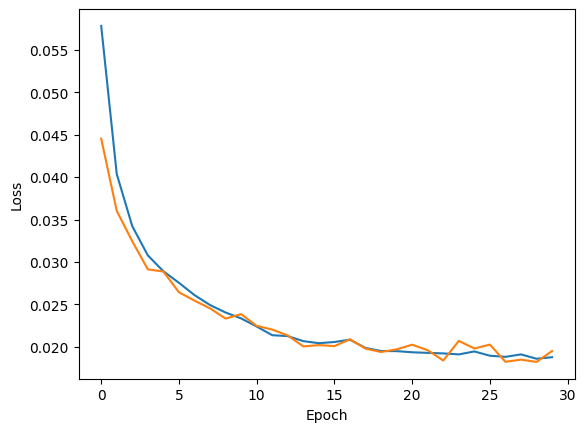

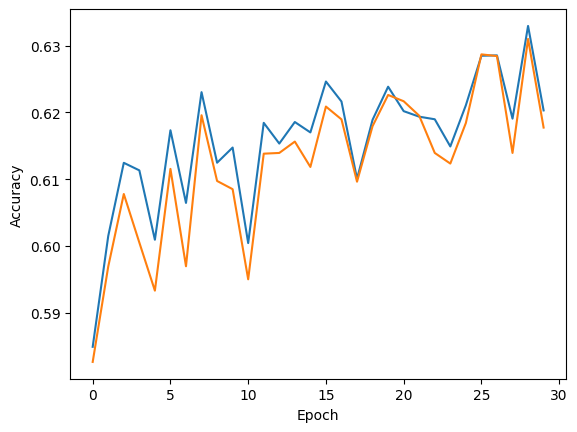

In [ ]:
#Plot the training and validation accuracy and loss
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_acc, label="Train Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.


##Model 1: BS 64, LR 1e-4, Epochs 30

Results: Training Accuracy .587, Validation Accuracy .584

Reasoning: Model training seemed too slow, the accuracy hadn't reached a plateau and there is no overfitting, so I'll increase lr and number of epochs to train faster and for a longer time.

##Model 2: BS 64, LR 0.005, Epochs 50

Results: Training Accuracy .630, Validation Accuracy .627

Reasoning: The model was able to train faster and reach a higher accuracy than model one. However, there was no significant growth after the 30th epoch so I will limit the next model to 30 epochs. Additionally, the model still wasn't showing overfitting so I will try to lower the batch size to help the network learn even faster.

##Model 3: BS 32, LR 0.005, Epochs 30

Results: Training Accuracy .603, Validation Accuracy .603

Reasoning: The model trained to about a .600 accuracy very quickly (about 10 epochs) but the accuracy failed to grow significantly after this point. As a result, I will return the batch size to 64, as in model 2, and try to increase learning speeds by further increasing the learning rate.

##Model 4: BS 64, LR 0.01, Epochs 30

Results: Training Accuracy .603, Validation Accuracy .600

Reasoning: The model again reached a .600 accuracy quickly, but then failed to improve anymore, instead the accuracy jumped up and down between .580 and .600.

##Final Model: Model 2: BS 64, LR 0.005, Epochs 50

Reasoning: Model 2 performed the best on the training and validation data.

In [ ]:
FinalAC=AutoEncoder()
train_loader=torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid, batch_size=64, shuffle=True)
train_loss, valid_loss, train_acc, valid_acc=train_net(FinalAC, train_loader, valid_loader, 30, 0.005)

Epoch 1: Train Loss: 0.06252764753488829, Train Accuracy: 0.594053266362819, Val Accuracy: 0.5916521990740741, Val Loss: 0.04296450546547158
Epoch 2: Train Loss: 0.037999151716732835, Train Accuracy: 0.6151365764425015, Val Accuracy: 0.6113642939814815, Val Loss: 0.034381926416942515
Epoch 3: Train Loss: 0.0319116002705932, Train Accuracy: 0.618314575388336, Val Accuracy: 0.6130642361111112, Val Loss: 0.0295426022924789
Epoch 4: Train Loss: 0.02835264771027098, Train Accuracy: 0.6154001178184975, Val Accuracy: 0.6103153935185185, Val Loss: 0.026803044091961156
Epoch 5: Train Loss: 0.02532676731178244, Train Accuracy: 0.6144544693516882, Val Accuracy: 0.6101345486111112, Val Loss: 0.024479673614036548
Epoch 6: Train Loss: 0.023228807756207462, Train Accuracy: 0.6081759836294298, Val Accuracy: 0.6044560185185185, Val Loss: 0.02300352399071602
Epoch 7: Train Loss: 0.021937793648583424, Train Accuracy: 0.6119353238458438, Val Accuracy: 0.6070601851851852, Val Loss: 0.021978092162984693
Epo

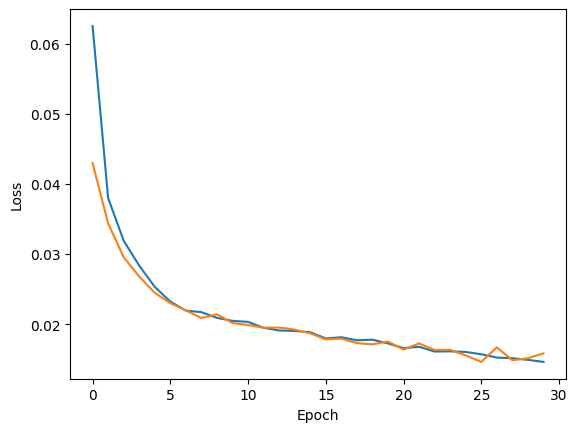

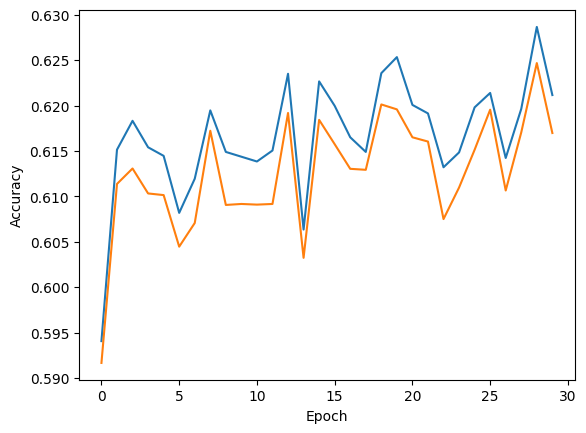

In [ ]:
#Plot training and validation loss and accuracy
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_acc, label="Train Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)
test_accuracy=get_accuracy(FinalAC, test_loader)
print(test_accuracy)

0.6224681712962963


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
#creates a dictionary to store the one hot encodings of the most common features
predict={}
zeros={} #also an dictionary of records for each feature without values to use in baseline models
for cols in catcols:
  start=cat_index[cols] #gets first column of one-hot encoding
  stop=cat_index[cols]+len(cat_values[cols]) #gets last column of one hot encoding
  colarr=train[:,start:stop]#Creates array of only the feature in one hot array
  col_sums=np.sum(colarr, axis=0)#Sums each array to find the max
  indofhighestsum=np.argmax(col_sums)#Finds the index of the max
  predict[cols]=np.zeros(stop-start)#Creates an array of zeros in the predict dictionary
  zeros[cols]=np.zeros(stop-start)#Creates an array of zeros in the zeros dictionary
  predict[cols][indofhighestsum]=1#assigns a 1 to the most common value of the array


for cols in catcols:
  print(f"{cols}: {predict[cols]}, {get_categorical_value(predict[cols], cols)}")

work: [0. 0. 1. 0. 0. 0. 0.], Private
marriage: [0. 0. 1. 0. 0. 0. 0.], Married-civ-spouse
occupation: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], Prof-specialty
edu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], HS-grad
relationship: [1. 0. 0. 0. 0. 0.], Husband
sex: [0. 1.], Male


In [ ]:
def baseline(data):
  "data is one row of a test np array"
  for cols in catcols:
    start=cat_index[cols]
    stop=cat_index[cols]+len(cat_values[cols])
    if np.array_equal(data[start:stop],zeros[cols]):
        data[start:stop]=predict[cols]

  return data

In [ ]:
def zero_out_baseline_feature(record, feature):
    """ Set the feature missing in record, by setting the appropriate
    columns of records to 0
    """
    start= cat_index[feature]
    stop= cat_index[feature] + len(cat_values[feature])
    record[start:stop]=zeros[feature]
    return record

def test_baseline(data):
  count=0
  acc=0

  for col in catcols:
    for row in data:
      x = zero_out_baseline_feature(np.copy(row), col)
      x = baseline(x)
      if np.array_equal(x, row):
        acc+=1
      count+=1
  return acc/count



In [ ]:
test_baseline(test)

0.46292679398148145

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

My auto encoder's test accuracy is significantly better than my baseline model's, about 15-percent.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
print(f"Normalized age: {test[0][0]}\nNormalized yredu: {test[0][1]}\nNormalized capgain: {test[0][2]}\nNormalized caploss: {test[0][3]}\nNormalized workhr: {test[0][4]}\nWork: {get_categorical_value(get_onehot(test[0], 'work'), 'work')}\nMarriage: {get_categorical_value(get_onehot(test[0], 'marriage'), 'marriage')}\nOccupation: {get_categorical_value(get_onehot(test[0], 'occupation'), 'occupation')}\nEducation: {get_categorical_value(get_onehot(test[0], 'edu'), 'edu')}\nRelationship: {get_categorical_value(get_onehot(test[0], 'relationship'), 'relationship')}\nSex: {get_categorical_value(get_onehot(test[0], 'sex'), 'sex')}")

Normalized age: 0.7123287916183472
Normalized yredu: 0.5333333611488342
Normalized capgain: 0.0
Normalized caploss: 0.0
Normalized workhr: 0.09183673560619354
Work: Private
Marriage: Married-civ-spouse
Occupation: Sales
Education: HS-grad
Relationship: Husband
Sex: Male


I do not think that it would be reasonable for a human to guess the education based upon the other features. Working in sales could be seen as a clue, but many people work in sales would have gotten a bachelor's degree. Features like workhr could apply to many jobs and other features such as relationship and sex do not seem related at all to education to a human.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
test_input = torch.from_numpy(zero_out_baseline_feature(test[0], "edu"))

acpred = FinalAC(test_input)

result = acpred.detach().numpy()

print(f"Prediction: {get_categorical_value(result, 'edu')}")

Prediction: Prof-school


The model predicts incorrectly.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
baselinepred = baseline(zero_out_baseline_feature(test[0], 'edu'))
print(f"Baseline Prediction: {get_categorical_value(get_onehot(baselinepred, 'edu'),'edu')}")

Baseline Prediction: HS-grad


The baseline predicts correctly, since it always will predict high school graduate for education.